In [21]:
import sklearn
print(sklearn.__version__)

1.3.2


In [22]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

#### 

#### Importando a base de dados feita com o script de coleta de dados a partir do Yahoofinance, atualmente para não pesar temos apenas 3 ativos. Mas podemos fazer todos ativos da bolsa disponível quando desejar.

In [23]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA


#### Ordenando por data e ticker e pegando a diferença do dia anterior.

In [24]:
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by = ['Ticker','Date'], inplace = True)

price_data['change_in_price'] = price_data['Close'].diff()
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999


In [25]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    return np.sign(data.shift(-d) - data)



# Aplicando a suavização exponencial
alpha = 0.20
price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 10 dias
d = 30
price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA,-0.026404,0.515601,1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA,-0.013185,0.508740,1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA,0.003296,0.503909,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA,0.009889,0.502023,1.0


In [26]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target_verify(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1  # Substitui os 0 por -1
    return target



# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)

# Calculando o target para d = 10 dias
d = 30
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)

price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,1.0,0.520882,1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA,-0.026404,0.515601,1.0,0.494478,1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA,-0.013185,0.508740,1.0,0.481293,1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA,0.003296,0.503909,1.0,0.484589,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA,0.009889,0.502023,1.0,0.494478,1.0


In [27]:
# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_30'] = price_data.groupby('Ticker')['Close'].shift(-30)
price_data['Smoothed_Close_30'] = price_data.groupby('Ticker')['Smoothed_Close'].shift(-30)

#### Tirando a diferença do 'Smoothed_Close' na virada de um tick para outro.

In [28]:
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)

price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

price_data[price_data.isna().any(axis = 1)]

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,1.0,0.520882,1.0,0.599993,0.574836
5721,2024-12-11,14.270000,14.360000,13.660000,13.800000,13.535663,49150600,ABEV3.SA,-0.470000,13.802750,NaN,13.800000,NaN,NaN,NaN
5722,2024-12-12,13.500000,13.580000,13.100000,13.100000,12.849072,49616900,ABEV3.SA,-0.700000,13.662200,NaN,13.100000,NaN,NaN,NaN
5723,2024-12-13,13.100000,13.360000,13.010000,13.080000,12.829453,30867900,ABEV3.SA,-0.020000,13.545760,NaN,13.080000,NaN,NaN,NaN
5724,2024-12-16,13.080000,13.420000,12.840000,12.840000,12.594051,32095500,ABEV3.SA,-0.240000,13.404608,NaN,12.840000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN


#### Calculando o RSI.

**Fórmula:**

\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}

In [29]:
# Período do indicador.
n = 14

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835


## Calculando o Stochastic Oscillator

**Fórmula:**

\begin{align}
\ K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [30]:
t = 14
low_t, high_t = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = t).max())

k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))

price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,57.575879
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,63.711767
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,58.980461
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,59.118061
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,58.565163


## Calculando o indicador Williams %R

**Fórmula:**

\begin{align}
\ R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [31]:
# Período de cálculo do indicador
t = 14

low_t, high_t = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()

#Aplicanod a função no grupo
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = t).max())

# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)

price_data[f'r_percent_{t}'] = r_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,57.575879,-42.424121
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,63.711767,-36.288233
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,58.980461,-41.019539
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,59.118061,-40.881939
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,58.565163,-41.434837


## Cálculo do indicador Moving Average Convergence Divergnece (MACD)

**Fórmula:**


\begin{align}
\ MACD = EMA_{12}(C) - EMA_{26}(C)
\end{align}

\begin{align}
\ SignalLine = EMA_{9}(MACD)
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ MACD = \text{Moving Average Convergence Divergence}
\end{align}
$

$
\begin{align}
\ C = \text{Closing Price}
\end{align}
$

$
\begin{align}
\ EMA_{n} = \text{n day Exponential Moving Average}
\end{align}
\\
$


In [32]:
# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd


price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,57.575879,-42.424121,-1.254436,-1.368394
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,63.711767,-36.288233,-1.171086,-1.328933
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,58.980461,-41.019539,-1.106101,-1.284366
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,59.118061,-40.881939,-1.042184,-1.235930
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,58.565163,-41.434837,-0.981827,-1.185109


### Cálculo do indicador Price Rate Of Change

**Formula:**


\begin{align}
\\
\ PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}
\\
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ PROC_{t} = \text{Price Rate of Change at time t}
\end{align}
$

$
\begin{align}
\ C_{t} = \text{Closing price at time t}
\end{align}
\\
$


In [33]:
# Período do indicador
e = 19

# Calculando o Price Rate
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = e))

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,57.575879,-42.424121,-1.254436,-1.368394,-0.049407
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,63.711767,-36.288233,-1.171086,-1.328933,-0.046759
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,58.980461,-41.019539,-1.106101,-1.284366,-0.046634
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,59.118061,-40.881939,-1.042184,-1.235930,-0.044524
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,58.565163,-41.434837,-0.981827,-1.185109,-0.042329


## Cálculo do indicador On Balance Volume

#### Formula:

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\\
\text{where,}\\
\\
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$


In [34]:
def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)
        

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)

price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,57.575879,-42.424121,-1.254436,-1.368394,-0.049407,2329297670
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,63.711767,-36.288233,-1.171086,-1.328933,-0.046759,2294652270
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,58.980461,-41.019539,-1.106101,-1.284366,-0.046634,2269554970
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,59.118061,-40.881939,-1.042184,-1.235930,-0.044524,2290075570
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,58.565163,-41.434837,-0.981827,-1.185109,-0.042329,2288822970


#### Salvando antes de tirar os Nans.

In [35]:
price_data.to_parquet('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D10.parquet', index=False)

In [36]:
# price_data.to_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D10.xlsx', index=False)

## Removendo Nans

In [37]:
# We need to remove all rows that have an NaN value.
print('Antes de tirar as NaN nós tinhamos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('Depois da retirada dos NaN temos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.tail()

Antes de tirar as NaN nós tinhamos 27044 linhas e 26 colunas
Depois da retirada dos NaN temos 26799 linhas e 26 colunas


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11749,2024-12-04,58.400002,58.480000,56.959999,57.330002,56.822830,25109200,VALE3.SA,-1.139999,58.150667,-1.0,57.330002,-1.0,54.020000,53.305458,1.139999,0.000000,38.153023,56.84,59.380001,51.601024,-48.398976,-0.760099,-0.680823,-0.062199,2407909370
11750,2024-12-05,57.459999,57.799999,56.869999,57.799999,57.288670,14160000,VALE3.SA,0.469997,58.080533,-1.0,57.799999,-1.0,52.660000,53.176367,0.000000,0.469997,44.056489,56.84,59.380001,48.839864,-51.160136,-0.747122,-0.694083,-0.061552,2393749370
11751,2024-12-06,57.470001,57.660000,56.750000,56.810001,56.307430,17897900,VALE3.SA,-0.989998,57.826427,-1.0,56.810001,-1.0,52.320000,53.005093,0.989998,0.000000,35.760334,56.75,59.380001,40.928759,-59.071241,-0.748711,-0.705009,-0.070673,2375851470
11752,2024-12-09,58.500000,60.189999,58.369999,59.830002,59.300713,40440600,VALE3.SA,3.020000,58.227142,-1.0,59.830002,-1.0,53.029999,53.010074,0.000000,3.020000,61.366753,56.75,60.189999,42.940186,-57.059814,-0.709459,-0.705899,-0.059414,2416292070
11753,2024-12-10,59.740002,59.939999,59.290001,59.770000,59.241245,13089300,VALE3.SA,-0.060001,58.535714,-1.0,59.770000,-1.0,52.910000,52.990059,0.060001,0.000000,60.811066,56.75,60.189999,51.910298,-48.089702,-0.646004,-0.693920,-0.044380,2429381370


## VALIDAÇÃO

### Geral

In [38]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI', f'k_percent_{t}', f'r_percent_{t}','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 220, oob_score = True, criterion = "gini", random_state = 0, n_jobs=-1)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  75.0


In [18]:
import warnings

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Selecionar colunas como array NumPy
X_Cols = price_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões e atualizar a coluna 'Prediction'
price_data['Prediction'] = rand_frst_clf.predict(X_Cols)

# Comparar valores e calcular a precisão
price_data['Match'] = (price_data['Prediction'] == price_data['Verify']).astype(int)  # 1 para igual, 0 para diferente
accuracy = price_data['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo: {accuracy:.2%}")



Precisão do modelo: 84.14%


In [53]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl']

### AMBEV

#### Time Series Cross-Validation.

In [39]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data_ABEV.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
5716,2024-12-04,13.90,14.06,13.78,13.93,13.663173,50659000,ABEV3.SA,0.08,13.132494,-1.0,13.93,-1.0,11.25,11.256312,0.00,0.08,82.325540,12.25,14.06,48.756539,-51.243461,-0.000375,-0.063355,0.029415,-2161176047
5717,2024-12-05,14.05,14.46,14.00,14.42,14.143786,38794000,ABEV3.SA,0.49,13.389995,-1.0,14.42,-1.0,11.02,11.209050,0.00,0.49,86.722945,12.25,14.46,51.583477,-48.416523,0.052492,-0.040186,0.053850,-2122382047
5718,2024-12-06,14.30,14.53,14.15,14.22,13.947618,46449200,ABEV3.SA,-0.20,13.555996,-1.0,14.22,-1.0,11.05,11.177240,0.20,0.00,77.627058,12.25,14.53,57.280530,-42.719470,0.106557,-0.010837,0.069538,-2075932847
5719,2024-12-09,14.22,14.33,14.14,14.21,13.937809,25321800,ABEV3.SA,-0.01,13.686797,-1.0,14.21,-1.0,10.87,11.115792,0.01,0.00,77.160149,12.25,14.53,63.017409,-36.982591,0.158135,0.022957,0.085762,-2050611047
5720,2024-12-10,14.33,14.50,14.27,14.27,13.996660,22942500,ABEV3.SA,0.06,13.803438,-1.0,14.27,-1.0,10.91,11.074633,0.00,0.06,78.073184,12.25,14.53,68.133232,-31.866768,0.206047,0.059575,0.096680,-2027668547


In [40]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")



Fold 1:


  Accuracy with Y_test (Prediction): 0.6221
  Accuracy with Verify: 0.6032
Fold 2:
  Accuracy with Y_test (Prediction): 0.3842
  Accuracy with Verify: 0.4000
Fold 3:
  Accuracy with Y_test (Prediction): 0.6284
  Accuracy with Verify: 0.5958
Fold 4:
  Accuracy with Y_test (Prediction): 0.6021
  Accuracy with Verify: 0.6011
Fold 5:
  Accuracy with Y_test (Prediction): 0.4979
  Accuracy with Verify: 0.5063

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.5469
  Média da acurácia com Verify: 0.5413


#### Walk-Forward Validation

In [41]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]


In [42]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_ABEV) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Ambev.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.6278
  Accuracy with Verify: 0.6389
Window 2:
  Accuracy with Y_test (Prediction): 0.2111
  Accuracy with Verify: 0.2000
Window 3:
  Accuracy with Y_test (Prediction): 0.7667
  Accuracy with Verify: 0.7278
Window 4:
  Accuracy with Y_test (Prediction): 0.5500
  Accuracy with Verify: 0.5833
Window 5:
  Accuracy with Y_test (Prediction): 0.6444
  Accuracy with Verify: 0.6000
Window 6:
  Accuracy with Y_test (Prediction): 0.8667
  Accuracy with Verify: 0.8444
Window 7:
  Accuracy with Y_test (Prediction): 0.4500
  Accuracy with Verify: 0.4722
Window 8:
  Accuracy with Y_test (Prediction): 0.3000
  Accuracy with Verify: 0.3556
Window 9:
  Accuracy with Y_test (Prediction): 0.1833
  Accuracy with Verify: 0.1833
Window 10:
  Accuracy with Y_test (Prediction): 0.4056
  Accuracy with Verify: 0.4222
Window 11:
  Accuracy with Y_test (Prediction): 0.2722
  Accuracy with Verify: 0.3500
Window 12:
  Accuracy with Y_test (Prediction): 0.5167
  Accura

#### Split normal sem cross-validation.

In [43]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]

Acurácia com Y_test (Prediction): 0.8394
Acurácia com Verify: 0.7637

Métricas para 'Prediction':
  Acurácia: 0.8394
  Precisão: 0.8311
  Recall: 0.9209
  F1-Score: 0.8737
  Specificidade: 0.7155

Métricas para 'Verify':
  Acurácia: 0.7637
  Precisão: 0.7566
  Recall: 0.8729
  F1-Score: 0.8106
  Specificidade: 0.6133


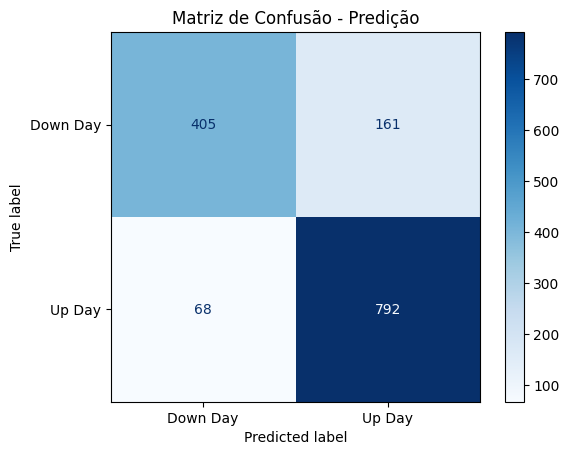

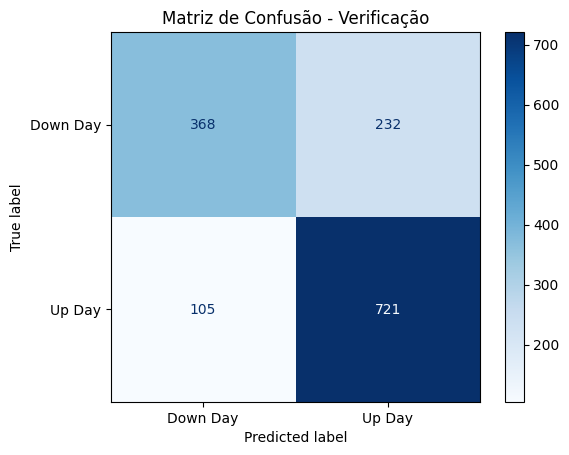

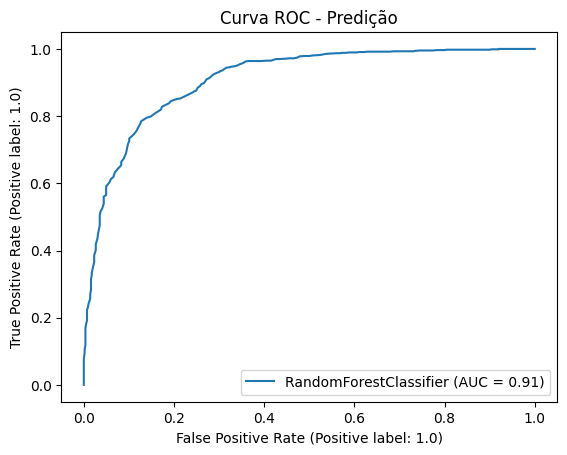

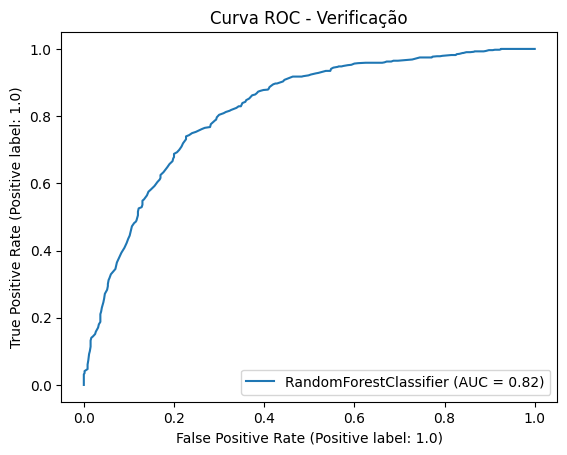

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Definir as colunas X e Y
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']  # Variável alvo para treinamento com preços suavizados
y_verify = price_data_ABEV['Verify']  # Direção do preço real

# Dividir X e Y em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0)

# Ajustar os dados ao modelo
rand_frst_clf_Ambev.fit(X_train, y_train)

# Fazer previsões com a direção de preço suavizada (Prediction)
y_pred = rand_frst_clf_Ambev.predict(X_test)

# Calcular a acurácia com base na direção suavizada do preço ('Prediction')
accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)

# Alinhar os índices de y_test e y_verify para a comparação correta
accuracy_verify = accuracy_score(y_verify.loc[y_test.index], y_pred)  # Comparação com Verify, usando o mesmo índice de y_test

# Print resultados de acurácia
print(f'Acurácia com Y_test (Prediction): {accuracy_ytest:.4f}')
print(f'Acurácia com Verify: {accuracy_verify:.4f}')

# Função para calcular as métricas adicionais
def calculate_additional_metrics(y_true, y_pred):
    # Calculando a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Extraindo os valores da matriz de confusão
    tn, fp, fn, tp = cm.ravel()  # true_negatives, false_positives, false_negatives, true_positives
    
    # Calculando as métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    recall = recall_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    f1 = f1_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    specificity = tn / (tn + fp)  # Specificidade
    
    return accuracy, precision, recall, f1, specificity

# Calculando as métricas para 'Prediction' (y_test)
accuracy_pred, precision_pred, recall_pred, f1_pred, specificity_pred = calculate_additional_metrics(y_test, y_pred)

# Calculando as métricas para 'Verify' (y_verify)
y_verify_pred = rand_frst_clf_Ambev.predict(X_test)  # As previsões já foram feitas com o modelo
accuracy_verify, precision_verify, recall_verify, f1_verify, specificity_verify = calculate_additional_metrics(y_verify.loc[y_test.index], y_verify_pred)

# Imprimindo as métricas calculadas
print(f"\nMétricas para 'Prediction':")
print(f"  Acurácia: {accuracy_pred:.4f}")
print(f"  Precisão: {precision_pred:.4f}")
print(f"  Recall: {recall_pred:.4f}")
print(f"  F1-Score: {f1_pred:.4f}")
print(f"  Specificidade: {specificity_pred:.4f}")

print(f"\nMétricas para 'Verify':")
print(f"  Acurácia: {accuracy_verify:.4f}")
print(f"  Precisão: {precision_verify:.4f}")
print(f"  Recall: {recall_verify:.4f}")
print(f"  F1-Score: {f1_verify:.4f}")
print(f"  Specificidade: {specificity_verify:.4f}")

# Matriz de Confusão para 'Prediction'
rf_matrix_pred = confusion_matrix(y_test, y_pred)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_pred, display_labels=['Down Day', 'Up Day'])
disp_pred.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Predição')
plt.show()

# Matriz de Confusão para 'Verify'
rf_matrix_verify = confusion_matrix(y_verify.loc[y_test.index], y_verify_pred)
disp_verify = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_verify, display_labels=['Down Day', 'Up Day'])
disp_verify.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Verificação')
plt.show()

# Curva ROC para 'Prediction'
rfc_disp_pred = RocCurveDisplay.from_estimator(rand_frst_clf_Ambev, X_test, y_test)
plt.title('Curva ROC - Predição')
plt.show()

# Curva ROC para 'Verify'
rfc_disp_verify = RocCurveDisplay.from_estimator(rand_frst_clf_Ambev, X_test, y_verify.loc[y_test.index])
plt.title('Curva ROC - Verificação')
plt.show()


#### Salvar modelo aprendido para AMBEV.

In [84]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Ambev, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl']

#### Carregar modelo. Geralmente carrego do modelo aprendido geral.

In [ ]:
# Carregar o modelo salvo
rand_frst_clf_Ambev = joblib.load('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

#### Utilizando a verificação da predicação com o preço real e não suavizado.

In [45]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_ABEV['Prediction'] = np.NaN  # Inicializando a coluna
price_data_ABEV['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_ABEV['Match'] = (price_data_ABEV['Prediction'] == price_data_ABEV['Verify']).astype(int)
overall_accuracy = price_data_ABEV['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_ABEV[price_data_ABEV['Date'] >= price_data_ABEV['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 85.93%

Precisão do modelo nos últimos 30 dias: 100.00%


#### Plotagem:

In [46]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]

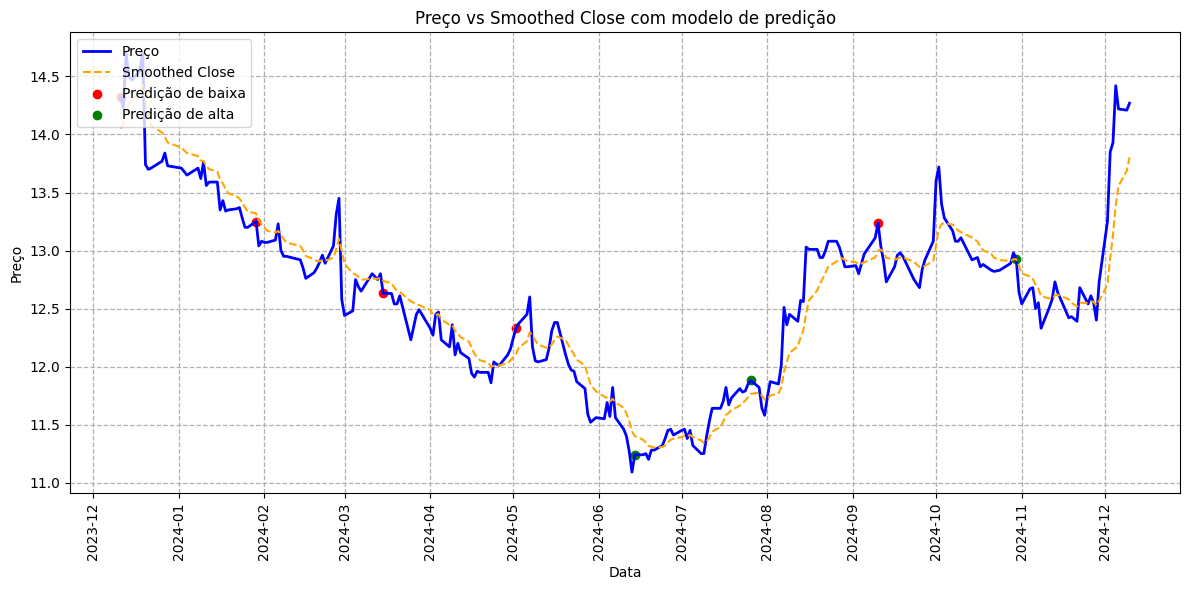

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ABEV3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Ambev.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Ambev.predict(X_Cols)

# Criando a figura
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
scatter_plotted = {"green": False, "red": False}  # Para controlar a legenda
for i in range(0, len(one_year_data), 30): 
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    label = "Predição de alta" if color == "green" else "Predição de baixa"

    # Para evitar repetição da legenda, plota uma vez cada cor
    if not scatter_plotted[color]:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label=label)
        scatter_plotted[color] = True
    else:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color)

# Configurações finais do gráfico
plt.xlabel("Data")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend(loc='upper left')
plt.grid(True, which="both", linestyle="--", linewidth=0.9)
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Exibe mais meses no eixo X

plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### ITAÚ

#### Time series Cross-Validation

In [56]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]
price_data_Itau.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
17884,2001-01-22,3.328138,3.328138,3.190707,3.212232,1.842811,39666861,ITUB4.SA,-0.115906,3.183127,-1.0,3.212232,-1.0,3.046653,2.982868,0.115906,0.000000,58.840366,2.947306,3.377811,54.777677,-45.222323,0.032415,0.017661,0.075180,1034153537
17885,2001-01-23,3.212232,3.245348,3.182594,3.182594,1.825808,95181141,ITUB4.SA,-0.029638,3.183020,-1.0,3.182594,-1.0,2.980422,2.982379,0.029638,0.000000,54.479523,3.046653,3.377811,41.178855,-58.821145,0.034654,0.021060,0.084546,938972396
17886,2001-01-24,3.228790,3.228790,3.094506,3.094506,1.775270,72183058,ITUB4.SA,-0.088088,3.165317,-1.0,3.094506,-1.0,2.844647,2.954832,0.088088,0.000000,43.438992,3.046653,3.377811,35.833125,-64.166875,0.034786,0.023805,0.086174,866789338
17887,2001-01-26,3.096327,3.212232,3.096162,3.179117,1.823813,105025383,ITUB4.SA,0.084611,3.168077,-1.0,3.179117,-1.0,2.798285,2.923523,0.000000,0.084611,53.812753,3.046653,3.377811,36.666546,-63.333454,0.034664,0.025977,0.086134,971814721
17888,2001-01-29,3.195675,3.195675,3.121164,3.129443,1.795315,78053367,ITUB4.SA,-0.049674,3.160350,-1.0,3.129443,-1.0,2.798285,2.898475,0.049674,0.000000,47.865791,3.046653,3.377811,34.333262,-65.666738,0.033629,0.027507,0.072718,893761354


In [57]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Variável adicional de verificação
verify = price_data_Itau['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=220 , oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:


  Accuracy with Y_test (Prediction): 0.5787
  Accuracy with Verify: 0.5549
Fold 2:
  Accuracy with Y_test (Prediction): 0.4689
  Accuracy with Verify: 0.4876
Fold 3:
  Accuracy with Y_test (Prediction): 0.5538
  Accuracy with Verify: 0.5300
Fold 4:
  Accuracy with Y_test (Prediction): 0.5124
  Accuracy with Verify: 0.5217
Fold 5:
  Accuracy with Y_test (Prediction): 0.5683
  Accuracy with Verify: 0.5455

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.5364
  Média da acurácia com Verify: 0.5280

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0    -1.0
1            1.0              1.0    -1.0
2            1.0              1.0    -1.0
3            1.0              1.0    -1.0
4            1.0             -1.0    -1.0
...          ...              ...     ...
4825        -1.0             -1.0     1.0
4826        -1.0             -1.0    -1.0
4827        -1.0             -1.0    -1.0
4828        -1.0             -1.0    -1.0
4829

#### Walk-Forward Validation

In [58]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

In [59]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Variável adicional de verificação
verify = price_data_Itau['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Itau) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Itau.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Itau.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.3889
  Accuracy with Verify: 0.3944
Window 2:
  Accuracy with Y_test (Prediction): 0.2333
  Accuracy with Verify: 0.2778
Window 3:
  Accuracy with Y_test (Prediction): 0.3556
  Accuracy with Verify: 0.3611
Window 4:
  Accuracy with Y_test (Prediction): 0.5889
  Accuracy with Verify: 0.5611
Window 5:
  Accuracy with Y_test (Prediction): 0.4000
  Accuracy with Verify: 0.4222
Window 6:
  Accuracy with Y_test (Prediction): 0.5889
  Accuracy with Verify: 0.6167
Window 7:
  Accuracy with Y_test (Prediction): 0.3722
  Accuracy with Verify: 0.3667
Window 8:
  Accuracy with Y_test (Prediction): 0.5833
  Accuracy with Verify: 0.5556
Window 9:
  Accuracy with Y_test (Prediction): 0.5056
  Accuracy with Verify: 0.4833
Window 10:
  Accuracy with Y_test (Prediction): 0.1778
  Accuracy with Verify: 0.2278
Window 11:
  Accuracy with Y_test (Prediction): 0.5556
  Accuracy with Verify: 0.5556
Window 12:
  Accuracy with Y_test (Prediction): 0.4833
  Accura

#### Split normal sem cross-validation.

In [60]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

Acurácia com Y_test (Prediction): 0.8076
Acurácia com Verify: 0.7448

Métricas para 'Prediction':
  Acurácia: 0.8076
  Precisão: 0.8179
  Recall: 0.8488
  F1-Score: 0.8330
  Specificidade: 0.7540

Métricas para 'Verify':
  Acurácia: 0.7448
  Precisão: 0.7603
  Recall: 0.7958
  F1-Score: 0.7776
  Specificidade: 0.6797


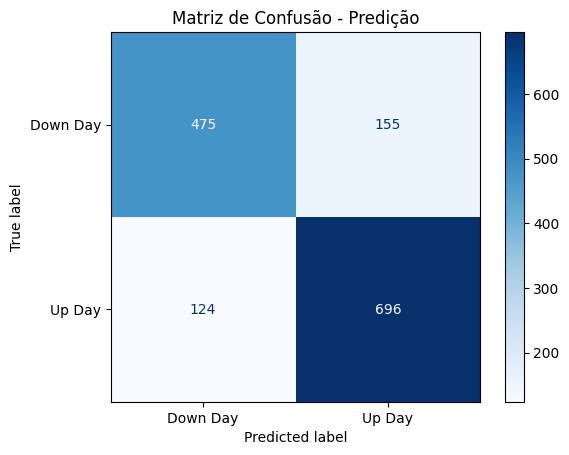

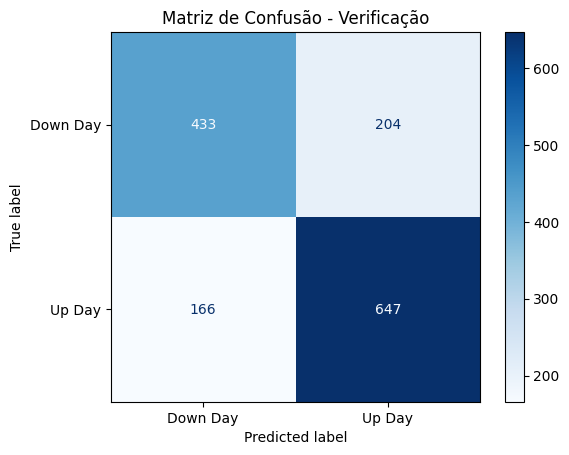

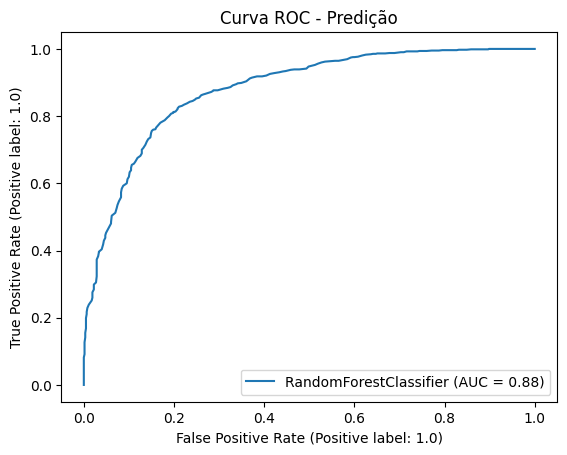

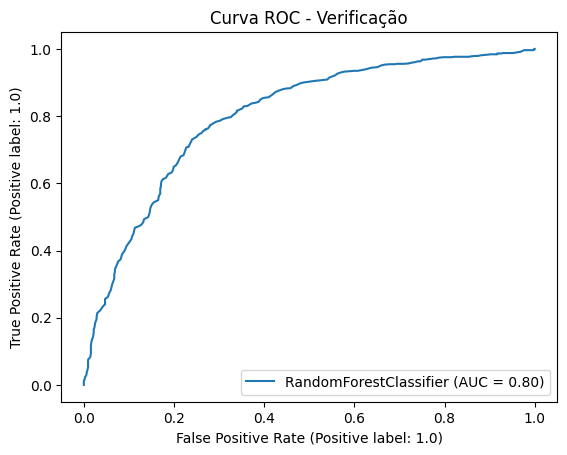

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Definir as colunas X e Y
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']  # Variável alvo para treinamento com preços suavizados
y_verify = price_data_Itau['Verify']  # Direção do preço real

# Dividir X e Y em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0)

# Ajustar os dados ao modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões com a direção de preço suavizada (Prediction)
y_pred = rand_frst_clf_Itau.predict(X_test)

# Calcular a acurácia com base na direção suavizada do preço ('Prediction')
accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)

# Alinhar os índices de y_test e y_verify para a comparação correta
accuracy_verify = accuracy_score(y_verify.loc[y_test.index], y_pred)  # Comparação com Verify, usando o mesmo índice de y_test

# Print resultados de acurácia
print(f'Acurácia com Y_test (Prediction): {accuracy_ytest:.4f}')
print(f'Acurácia com Verify: {accuracy_verify:.4f}')

# Função para calcular as métricas adicionais
def calculate_additional_metrics(y_true, y_pred):
    # Calculando a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Extraindo os valores da matriz de confusão
    tn, fp, fn, tp = cm.ravel()  # true_negatives, false_positives, false_negatives, true_positives
    
    # Calculando as métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    recall = recall_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    f1 = f1_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    specificity = tn / (tn + fp)  # Specificidade
    
    return accuracy, precision, recall, f1, specificity

# Calculando as métricas para 'Prediction' (y_test)
accuracy_pred, precision_pred, recall_pred, f1_pred, specificity_pred = calculate_additional_metrics(y_test, y_pred)

# Calculando as métricas para 'Verify' (y_verify)
y_verify_pred = rand_frst_clf_Itau.predict(X_test)  # As previsões já foram feitas com o modelo
accuracy_verify, precision_verify, recall_verify, f1_verify, specificity_verify = calculate_additional_metrics(y_verify.loc[y_test.index], y_verify_pred)

# Imprimindo as métricas calculadas
print(f"\nMétricas para 'Prediction':")
print(f"  Acurácia: {accuracy_pred:.4f}")
print(f"  Precisão: {precision_pred:.4f}")
print(f"  Recall: {recall_pred:.4f}")
print(f"  F1-Score: {f1_pred:.4f}")
print(f"  Specificidade: {specificity_pred:.4f}")

print(f"\nMétricas para 'Verify':")
print(f"  Acurácia: {accuracy_verify:.4f}")
print(f"  Precisão: {precision_verify:.4f}")
print(f"  Recall: {recall_verify:.4f}")
print(f"  F1-Score: {f1_verify:.4f}")
print(f"  Specificidade: {specificity_verify:.4f}")

# Matriz de Confusão para 'Prediction'
rf_matrix_pred = confusion_matrix(y_test, y_pred)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_pred, display_labels=['Down Day', 'Up Day'])
disp_pred.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Predição')
plt.show()

# Matriz de Confusão para 'Verify'
rf_matrix_verify = confusion_matrix(y_verify.loc[y_test.index], y_verify_pred)
disp_verify = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_verify, display_labels=['Down Day', 'Up Day'])
disp_verify.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Verificação')
plt.show()

# Curva ROC para 'Prediction'
rfc_disp_pred = RocCurveDisplay.from_estimator(rand_frst_clf_Itau, X_test, y_test)
plt.title('Curva ROC - Predição')
plt.show()

# Curva ROC para 'Verify'
rfc_disp_verify = RocCurveDisplay.from_estimator(rand_frst_clf_Itau, X_test, y_verify.loc[y_test.index])
plt.title('Curva ROC - Verificação')
plt.show()


#### Salvar modelo aprendido para ITAU.

In [247]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Itau, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [248]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Itau['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Itau['Prediction'] = rand_frst_clf_Itau.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Itau['Match'] = (price_data_Itau['Prediction'] == price_data_Itau['Verify']).astype(int)
overall_accuracy = price_data_Itau['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Itau[price_data_Itau['Date'] >= price_data_Itau['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Itau.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 81.32%

Precisão do modelo nos últimos 30 dias: 85.00%


#### Plotagem:

In [62]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

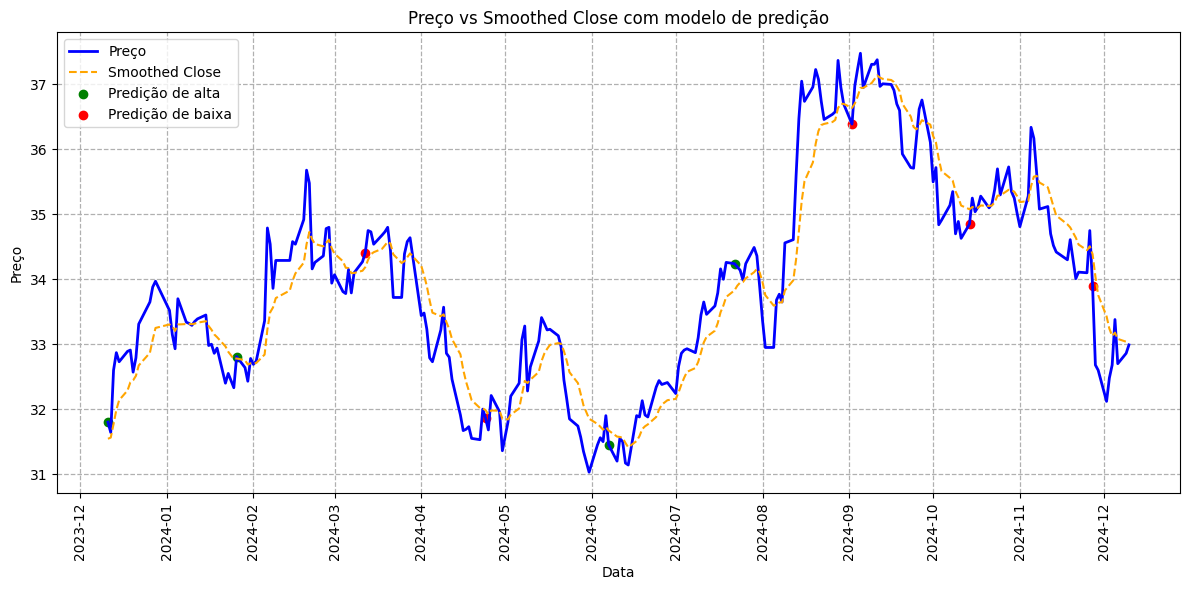

In [63]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ITUB4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Ambev.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Ambev.predict(X_Cols)

# Criando a figura
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
scatter_plotted = {"green": False, "red": False}  # Para controlar a legenda
for i in range(0, len(one_year_data), 30): 
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    label = "Predição de alta" if color == "green" else "Predição de baixa"

    # Para evitar repetição da legenda, plota uma vez cada cor
    if not scatter_plotted[color]:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label=label)
        scatter_plotted[color] = True
    else:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color)

# Configurações finais do gráfico
plt.xlabel("Data")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend(loc='upper left')
plt.grid(True, which="both", linestyle="--", linewidth=0.9)
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Exibe mais meses no eixo X

plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### MAGALU

#### Time series Cross-Validation

In [64]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]
price_data_Magalu.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
23731,2011-05-31,4.676616,4.676616,4.574315,4.676616,4.307227,3846883,MGLU3.SA,0.014614,4.637045,1.0,4.676616,-1.0,4.603544,4.707241,0.0,0.014614,53.311868,4.43694,4.822760,51.864741,-48.135259,-0.027713,-0.024024,-0.035586,-17479521
23732,2011-06-01,4.638619,4.755534,4.612313,4.735074,4.361068,1503309,MGLU3.SA,0.058458,4.656651,-1.0,4.735074,-1.0,4.384328,4.642659,0.0,0.058458,60.345428,4.43694,4.799377,60.620330,-39.379670,-0.025983,-0.024415,-0.029739,-15976212
23733,2011-06-02,4.676616,4.822760,4.676616,4.793532,4.414908,1482439,MGLU3.SA,0.058458,4.684027,-1.0,4.793532,-1.0,4.238183,4.561763,0.0,0.058458,66.217696,4.43694,4.822760,64.041960,-35.958040,-0.022497,-0.024032,-0.024747,-14493773
23734,2011-06-03,4.735074,4.881218,4.735074,4.881218,4.495669,1386643,MGLU3.SA,0.087686,4.723465,-1.0,4.881218,-1.0,4.054042,4.460219,0.0,0.087686,73.109680,4.43694,4.881218,64.492280,-35.507720,-0.016847,-0.022595,-0.015913,-13107130
23735,2011-06-06,4.843221,4.916293,4.811069,4.881218,4.495669,1116362,MGLU3.SA,0.000000,4.755016,-1.0,4.881218,-1.0,4.325870,4.433349,0.0,0.000000,73.109680,4.43694,4.916293,66.355165,-33.644835,-0.010092,-0.020094,-0.007386,-11990768


In [65]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Variável adicional de verificação
verify = price_data_Magalu['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Magalu.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Magalu.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.6307
  Accuracy with Verify: 0.5941
Fold 2:
  Accuracy with Y_test (Prediction): 0.3437
  Accuracy with Verify: 0.3620
Fold 3:
  Accuracy with Y_test (Prediction): 0.5539
  Accuracy with Verify: 0.5558
Fold 4:
  Accuracy with Y_test (Prediction): 0.4954
  Accuracy with Verify: 0.4881
Fold 5:
  Accuracy with Y_test (Prediction): 0.4022
  Accuracy with Verify: 0.3291

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.4852
  Média da acurácia com Verify: 0.4658

Comparação:
      Prediction  Y_Test (Actual)  Verify
0           -1.0              1.0     1.0
1            1.0              1.0     1.0
2           -1.0              1.0     1.0
3           -1.0              1.0     1.0
4           -1.0              1.0     1.0
...          ...              ...     ...
2730         1.0             -1.0    -1.0
2731         1.0             -1.0    -1.0
2732         1.0             -1.0    -1.0
2733         1.0             -1.0    -

#### Walk-Forward Validation

In [66]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

In [67]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Variável adicional de verificação
verify = price_data_Magalu['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Magalu) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Magalu.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Magalu.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.7611
  Accuracy with Verify: 0.7500
Window 2:
  Accuracy with Y_test (Prediction): 0.5833
  Accuracy with Verify: 0.5556
Window 3:
  Accuracy with Y_test (Prediction): 0.7500
  Accuracy with Verify: 0.7222
Window 4:
  Accuracy with Y_test (Prediction): 0.4389
  Accuracy with Verify: 0.4611
Window 5:
  Accuracy with Y_test (Prediction): 0.2333
  Accuracy with Verify: 0.2556
Window 6:
  Accuracy with Y_test (Prediction): 0.9333
  Accuracy with Verify: 0.8833
Window 7:
  Accuracy with Y_test (Prediction): 0.6833
  Accuracy with Verify: 0.6778
Window 8:
  Accuracy with Y_test (Prediction): 0.4333
  Accuracy with Verify: 0.4556
Window 9:
  Accuracy with Y_test (Prediction): 0.8500
  Accuracy with Verify: 0.7833
Window 10:
  Accuracy with Y_test (Prediction): 0.7778
  Accuracy with Verify: 0.7611
Window 11:
  Accuracy with Y_test (Prediction): 0.2056
  Accuracy with Verify: 0.2167
Window 12:
  Accuracy with Y_test (Prediction): 0.3222
  Accura

#### Split normal sem cross-validation.

In [68]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

Acurácia com Y_test (Prediction): 0.8794
Acurácia com Verify: 0.8210

Métricas para 'Prediction':
  Acurácia: 0.8794
  Precisão: 0.8813
  Recall: 0.8915
  F1-Score: 0.8863
  Specificidade: 0.8660

Métricas para 'Verify':
  Acurácia: 0.8210
  Precisão: 0.8242
  Recall: 0.8376
  F1-Score: 0.8308
  Specificidade: 0.8026


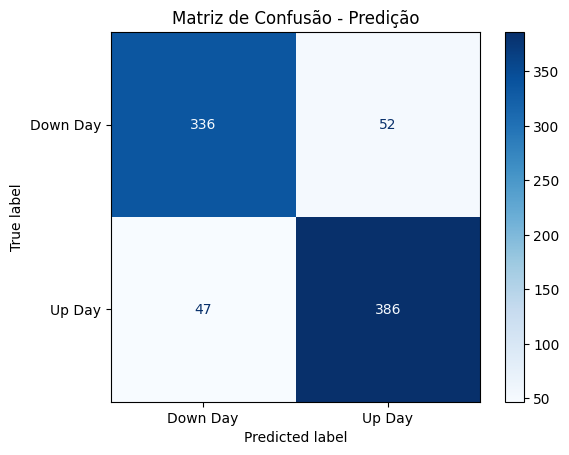

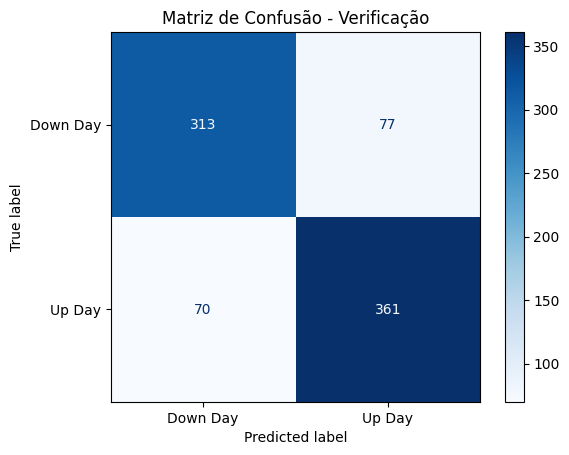

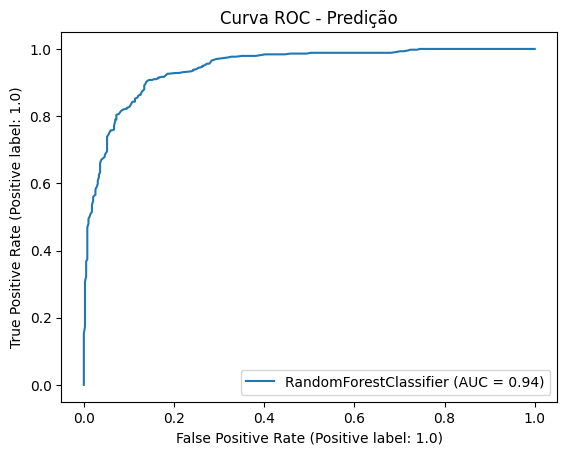

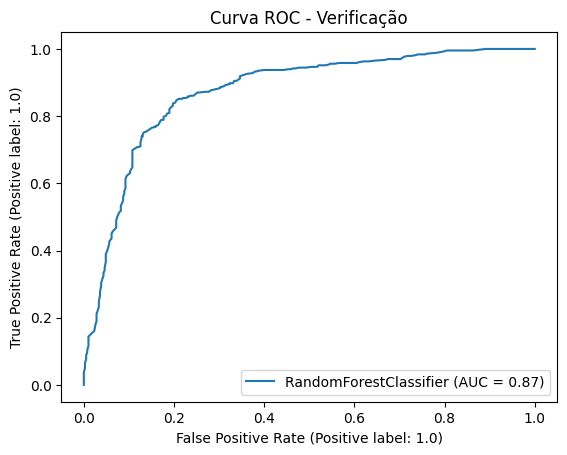

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Definir as colunas X e Y
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']  # Variável alvo para treinamento com preços suavizados
y_verify = price_data_Magalu['Verify']  # Direção do preço real

# Dividir X e Y em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0)

# Ajustar os dados ao modelo
rand_frst_clf_Magalu.fit(X_train, y_train)

# Fazer previsões com a direção de preço suavizada (Prediction)
y_pred = rand_frst_clf_Magalu.predict(X_test)

# Calcular a acurácia com base na direção suavizada do preço ('Prediction')
accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)

# Alinhar os índices de y_test e y_verify para a comparação correta
accuracy_verify = accuracy_score(y_verify.loc[y_test.index], y_pred)  # Comparação com Verify, usando o mesmo índice de y_test

# Print resultados de acurácia
print(f'Acurácia com Y_test (Prediction): {accuracy_ytest:.4f}')
print(f'Acurácia com Verify: {accuracy_verify:.4f}')

# Função para calcular as métricas adicionais
def calculate_additional_metrics(y_true, y_pred):
    # Calculando a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Extraindo os valores da matriz de confusão
    tn, fp, fn, tp = cm.ravel()  # true_negatives, false_positives, false_negatives, true_positives
    
    # Calculando as métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    recall = recall_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    f1 = f1_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    specificity = tn / (tn + fp)  # Specificidade
    
    return accuracy, precision, recall, f1, specificity

# Calculando as métricas para 'Prediction' (y_test)
accuracy_pred, precision_pred, recall_pred, f1_pred, specificity_pred = calculate_additional_metrics(y_test, y_pred)

# Calculando as métricas para 'Verify' (y_verify)
y_verify_pred = rand_frst_clf_Magalu.predict(X_test)  # As previsões já foram feitas com o modelo
accuracy_verify, precision_verify, recall_verify, f1_verify, specificity_verify = calculate_additional_metrics(y_verify.loc[y_test.index], y_verify_pred)

# Imprimindo as métricas calculadas
print(f"\nMétricas para 'Prediction':")
print(f"  Acurácia: {accuracy_pred:.4f}")
print(f"  Precisão: {precision_pred:.4f}")
print(f"  Recall: {recall_pred:.4f}")
print(f"  F1-Score: {f1_pred:.4f}")
print(f"  Specificidade: {specificity_pred:.4f}")

print(f"\nMétricas para 'Verify':")
print(f"  Acurácia: {accuracy_verify:.4f}")
print(f"  Precisão: {precision_verify:.4f}")
print(f"  Recall: {recall_verify:.4f}")
print(f"  F1-Score: {f1_verify:.4f}")
print(f"  Specificidade: {specificity_verify:.4f}")

# Matriz de Confusão para 'Prediction'
rf_matrix_pred = confusion_matrix(y_test, y_pred)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_pred, display_labels=['Down Day', 'Up Day'])
disp_pred.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Predição')
plt.show()

# Matriz de Confusão para 'Verify'
rf_matrix_verify = confusion_matrix(y_verify.loc[y_test.index], y_verify_pred)
disp_verify = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_verify, display_labels=['Down Day', 'Up Day'])
disp_verify.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Verificação')
plt.show()

# Curva ROC para 'Prediction'
rfc_disp_pred = RocCurveDisplay.from_estimator(rand_frst_clf_Magalu, X_test, y_test)
plt.title('Curva ROC - Predição')
plt.show()

# Curva ROC para 'Verify'
rfc_disp_verify = RocCurveDisplay.from_estimator(rand_frst_clf_Magalu, X_test, y_verify.loc[y_test.index])
plt.title('Curva ROC - Verificação')
plt.show()


#### Salvar modelo aprendido para MAGALU.

In [87]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Magalu, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl']

#### Utilizando a verificação da predição com o preço real e não suavizado. Manter cross-validation.

In [70]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Magalu['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Magalu['Prediction'] = rand_frst_clf_Magalu.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Magalu['Match'] = (price_data_Magalu['Prediction'] == price_data_Magalu['Verify']).astype(int)
overall_accuracy = price_data_Magalu['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Magalu[price_data_Magalu['Date'] >= price_data_Magalu['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Magalu.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 88.55%

Precisão do modelo nos últimos 30 dias: 100.00%


#### Plotagem:

In [71]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

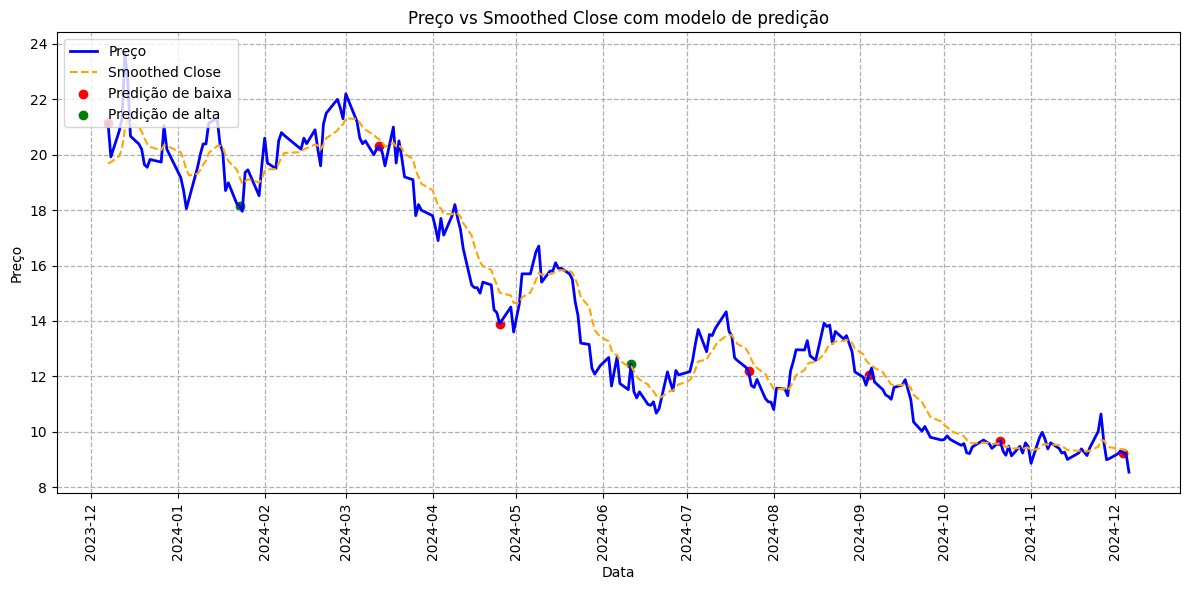

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'MGLU3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Ambev.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Ambev.predict(X_Cols)

# Criando a figura
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
scatter_plotted = {"green": False, "red": False}  # Para controlar a legenda
for i in range(0, len(one_year_data), 30): 
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    label = "Predição de alta" if color == "green" else "Predição de baixa"

    # Para evitar repetição da legenda, plota uma vez cada cor
    if not scatter_plotted[color]:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label=label)
        scatter_plotted[color] = True
    else:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color)

# Configurações finais do gráfico
plt.xlabel("Data")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend(loc='upper left')
plt.grid(True, which="both", linestyle="--", linewidth=0.9)
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Exibe mais meses no eixo X

plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


#### Time series Cross-Validation

In [73]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]
price_data_Petro.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
17830,2024-12-04,39.500000,39.860001,38.980000,39.250000,36.389229,31584400,PETR4.SA,-0.250000,38.888980,-1.0,39.250000,-1.0,37.299999,37.104151,0.250000,0.000000,66.767374,36.529999,39.860001,70.840239,-29.159761,0.584023,0.360703,0.086489,-150627253651
17831,2024-12-05,39.389999,39.810001,39.209999,39.639999,36.750801,25214200,PETR4.SA,0.389999,39.039184,-1.0,39.639999,-1.0,37.090000,37.101321,0.000000,0.389999,71.827634,36.860001,39.860001,72.639443,-27.360557,0.618615,0.412285,0.093087,-150602039451
17832,2024-12-06,39.639999,39.700001,38.959999,39.029999,36.185261,31118500,PETR4.SA,-0.610001,39.037347,-1.0,39.029999,-1.0,36.830002,37.047057,0.610001,0.000000,56.344078,37.200001,39.860001,69.073166,-30.926834,0.638521,0.457533,0.094290,-150633157951
17833,2024-12-09,39.380001,40.169998,39.360001,40.040001,37.121647,28548700,PETR4.SA,1.010002,39.237878,-1.0,40.040001,-1.0,36.639999,36.965646,0.000000,1.010002,69.078508,37.549999,40.169998,64.422868,-35.577132,0.662837,0.498594,0.096798,-150604609251
17834,2024-12-10,40.299999,40.430000,40.110001,40.189999,37.260712,21837600,PETR4.SA,0.149998,39.428302,-1.0,40.189999,-1.0,36.810001,36.934517,0.000000,0.149998,70.550562,37.549999,40.430000,65.218818,-34.781182,0.689525,0.536780,0.099201,-150582771651


In [74]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Variável adicional de verificação
verify = price_data_Petro['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.5920
  Accuracy with Verify: 0.5881
Fold 2:
  Accuracy with Y_test (Prediction): 0.3970
  Accuracy with Verify: 0.4239
Fold 3:
  Accuracy with Y_test (Prediction): 0.5075
  Accuracy with Verify: 0.5134
Fold 4:
  Accuracy with Y_test (Prediction): 0.4517
  Accuracy with Verify: 0.4507
Fold 5:
  Accuracy with Y_test (Prediction): 0.5025
  Accuracy with Verify: 0.4736

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.4901
  Média da acurácia com Verify: 0.4900

Comparação:
      Prediction  Y_Test (Actual)  Verify
0           -1.0             -1.0    -1.0
1           -1.0             -1.0    -1.0
2           -1.0             -1.0    -1.0
3           -1.0             -1.0    -1.0
4           -1.0             -1.0    -1.0
...          ...              ...     ...
5020        -1.0             -1.0    -1.0
5021        -1.0             -1.0    -1.0
5022        -1.0             -1.0    -1.0
5023        -1.0             -1.0    -

#### Walk-Forward Validation

In [75]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

In [76]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Variável adicional de verificação
verify = price_data_Petro['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Petro) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Petro.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Petro.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.4556
  Accuracy with Verify: 0.5222
Window 2:
  Accuracy with Y_test (Prediction): 0.6056
  Accuracy with Verify: 0.6000
Window 3:
  Accuracy with Y_test (Prediction): 0.1889
  Accuracy with Verify: 0.2333
Window 4:
  Accuracy with Y_test (Prediction): 0.6833
  Accuracy with Verify: 0.6889
Window 5:
  Accuracy with Y_test (Prediction): 0.3778
  Accuracy with Verify: 0.4000
Window 6:
  Accuracy with Y_test (Prediction): 0.5889
  Accuracy with Verify: 0.5944
Window 7:
  Accuracy with Y_test (Prediction): 0.6000
  Accuracy with Verify: 0.5222
Window 8:
  Accuracy with Y_test (Prediction): 0.7000
  Accuracy with Verify: 0.6278
Window 9:
  Accuracy with Y_test (Prediction): 0.5000
  Accuracy with Verify: 0.4167
Window 10:
  Accuracy with Y_test (Prediction): 0.2667
  Accuracy with Verify: 0.3444
Window 11:
  Accuracy with Y_test (Prediction): 0.5000
  Accuracy with Verify: 0.4611
Window 12:
  Accuracy with Y_test (Prediction): 0.6444
  Accura

#### Split normal sem cross-validation.

In [77]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

Acurácia com Y_test (Prediction): 0.7918
Acurácia com Verify: 0.7321

Métricas para 'Prediction':
  Acurácia: 0.7918
  Precisão: 0.7711
  Recall: 0.8750
  F1-Score: 0.8197
  Specificidade: 0.6936

Métricas para 'Verify':
  Acurácia: 0.7321
  Precisão: 0.7289
  Recall: 0.8152
  F1-Score: 0.7697
  Specificidade: 0.6309


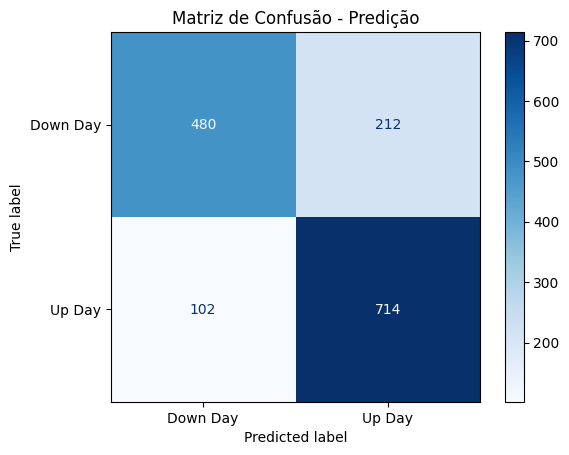

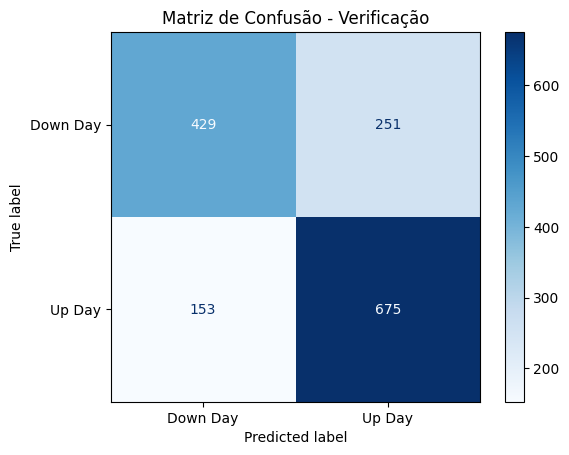

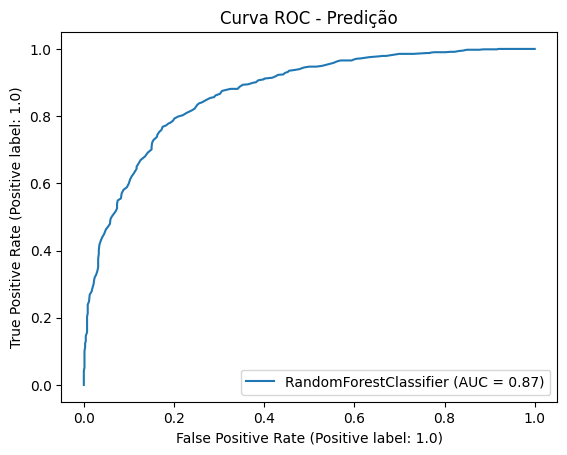

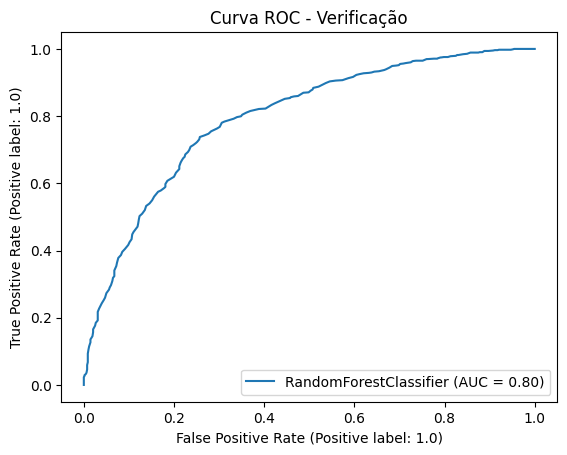

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Definir as colunas X e Y
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']  # Variável alvo para treinamento com preços suavizados
y_verify = price_data_Petro['Verify']  # Direção do preço real

# Dividir X e Y em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0)

# Ajustar os dados ao modelo
rand_frst_clf_Petro.fit(X_train, y_train)

# Fazer previsões com a direção de preço suavizada (Prediction)
y_pred = rand_frst_clf_Petro.predict(X_test)

# Calcular a acurácia com base na direção suavizada do preço ('Prediction')
accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)

# Alinhar os índices de y_test e y_verify para a comparação correta
accuracy_verify = accuracy_score(y_verify.loc[y_test.index], y_pred)  # Comparação com Verify, usando o mesmo índice de y_test

# Print resultados de acurácia
print(f'Acurácia com Y_test (Prediction): {accuracy_ytest:.4f}')
print(f'Acurácia com Verify: {accuracy_verify:.4f}')

# Função para calcular as métricas adicionais
def calculate_additional_metrics(y_true, y_pred):
    # Calculando a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Extraindo os valores da matriz de confusão
    tn, fp, fn, tp = cm.ravel()  # true_negatives, false_positives, false_negatives, true_positives
    
    # Calculando as métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    recall = recall_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    f1 = f1_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    specificity = tn / (tn + fp)  # Specificidade
    
    return accuracy, precision, recall, f1, specificity

# Calculando as métricas para 'Prediction' (y_test)
accuracy_pred, precision_pred, recall_pred, f1_pred, specificity_pred = calculate_additional_metrics(y_test, y_pred)

# Calculando as métricas para 'Verify' (y_verify)
y_verify_pred = rand_frst_clf_Petro.predict(X_test)  # As previsões já foram feitas com o modelo
accuracy_verify, precision_verify, recall_verify, f1_verify, specificity_verify = calculate_additional_metrics(y_verify.loc[y_test.index], y_verify_pred)

# Imprimindo as métricas calculadas
print(f"\nMétricas para 'Prediction':")
print(f"  Acurácia: {accuracy_pred:.4f}")
print(f"  Precisão: {precision_pred:.4f}")
print(f"  Recall: {recall_pred:.4f}")
print(f"  F1-Score: {f1_pred:.4f}")
print(f"  Specificidade: {specificity_pred:.4f}")

print(f"\nMétricas para 'Verify':")
print(f"  Acurácia: {accuracy_verify:.4f}")
print(f"  Precisão: {precision_verify:.4f}")
print(f"  Recall: {recall_verify:.4f}")
print(f"  F1-Score: {f1_verify:.4f}")
print(f"  Specificidade: {specificity_verify:.4f}")

# Matriz de Confusão para 'Prediction'
rf_matrix_pred = confusion_matrix(y_test, y_pred)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_pred, display_labels=['Down Day', 'Up Day'])
disp_pred.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Predição')
plt.show()

# Matriz de Confusão para 'Verify'
rf_matrix_verify = confusion_matrix(y_verify.loc[y_test.index], y_verify_pred)
disp_verify = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_verify, display_labels=['Down Day', 'Up Day'])
disp_verify.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Verificação')
plt.show()

# Curva ROC para 'Prediction'
rfc_disp_pred = RocCurveDisplay.from_estimator(rand_frst_clf_Petro, X_test, y_test)
plt.title('Curva ROC - Predição')
plt.show()

# Curva ROC para 'Verify'
rfc_disp_verify = RocCurveDisplay.from_estimator(rand_frst_clf_Petro, X_test, y_verify.loc[y_test.index])
plt.title('Curva ROC - Verificação')
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [100]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Petro, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [79]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Petro['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Petro['Prediction'] = rand_frst_clf_Petro.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Petro['Match'] = (price_data_Petro['Prediction'] == price_data_Petro['Verify']).astype(int)
overall_accuracy = price_data_Petro['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Petro[price_data_Petro['Date'] >= price_data_Petro['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Petro.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 85.21%

Precisão do modelo nos últimos 30 dias: 80.00%


#### Plotagem:

In [80]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

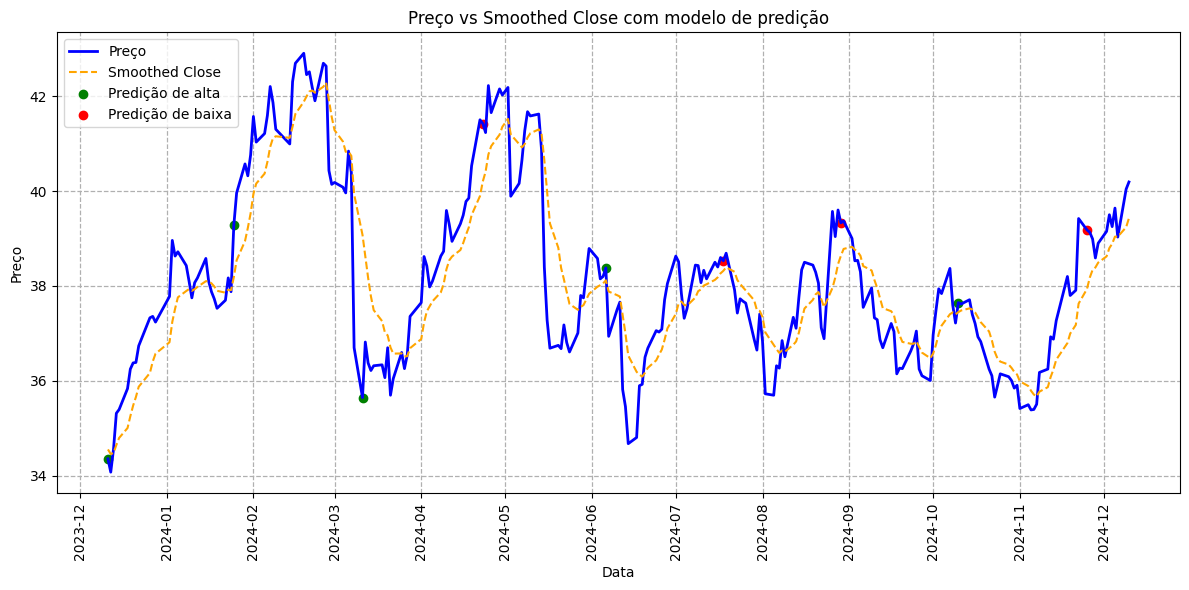

In [81]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'PETR4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Ambev.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Ambev.predict(X_Cols)

# Criando a figura
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
scatter_plotted = {"green": False, "red": False}  # Para controlar a legenda
for i in range(0, len(one_year_data), 30): 
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    label = "Predição de alta" if color == "green" else "Predição de baixa"

    # Para evitar repetição da legenda, plota uma vez cada cor
    if not scatter_plotted[color]:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label=label)
        scatter_plotted[color] = True
    else:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color)

# Configurações finais do gráfico
plt.xlabel("Data")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend(loc='upper left')
plt.grid(True, which="both", linestyle="--", linewidth=0.9)
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Exibe mais meses no eixo X

plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Vale.

#### Time series Cross-Validation

In [82]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]
price_data_Vale.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
5770,2000-02-04,3.750000,3.891666,3.750000,3.891666,1.694520,345600,VALE3.SA,0.141666,3.879920,-1.0,3.891666,-1.0,3.291666,3.120391,0.000000,0.141666,52.400509,3.708333,4.166666,37.437162,-62.562838,0.044518,0.045051,0.108549,16584000
5771,2000-02-07,3.916666,4.083333,3.916666,4.083333,1.777976,81600,VALE3.SA,0.191667,3.920603,-1.0,4.083333,-1.0,3.191666,3.134646,0.000000,0.191667,65.750992,3.708333,4.166666,46.313377,-53.686623,0.043158,0.044672,0.125532,16665600
5772,2000-02-08,4.083333,4.320833,4.083333,4.320833,1.881389,1036800,VALE3.SA,0.237500,4.000649,-1.0,4.320833,-1.0,3.251666,3.158050,0.000000,0.237500,75.554120,3.708333,4.320833,47.724987,-52.275013,0.046960,0.045130,0.152925,17702400
5773,2000-02-09,4.258333,4.366666,4.250000,4.250000,1.850546,6081600,VALE3.SA,-0.070833,4.050519,-1.0,4.250000,-1.0,3.248333,3.176106,0.070833,0.000000,68.779335,3.708333,4.366666,51.977646,-48.022354,0.052740,0.046652,0.162495,23784000
5774,2000-02-10,4.250000,4.250000,4.000000,4.000000,1.741691,3969600,VALE3.SA,-0.250000,4.040415,-1.0,4.000000,-1.0,3.333333,3.207552,0.250000,0.000000,50.381726,3.708333,4.366666,50.442893,-49.557107,0.055912,0.048504,0.136822,19814400


In [83]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Variável adicional de verificação
verify = price_data_Vale['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.5296
  Accuracy with Verify: 0.5025
Fold 2:
  Accuracy with Y_test (Prediction): 0.5125
  Accuracy with Verify: 0.4955
Fold 3:
  Accuracy with Y_test (Prediction): 0.4223
  Accuracy with Verify: 0.4393
Fold 4:
  Accuracy with Y_test (Prediction): 0.5256
  Accuracy with Verify: 0.4995
Fold 5:
  Accuracy with Y_test (Prediction): 0.5085
  Accuracy with Verify: 0.4804

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.4997
  Média da acurácia com Verify: 0.4835

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0     1.0
2           -1.0              1.0     1.0
3           -1.0              1.0     1.0
4           -1.0              1.0     1.0
...          ...              ...     ...
4980         1.0             -1.0    -1.0
4981         1.0             -1.0    -1.0
4982         1.0             -1.0    -1.0
4983         1.0             -1.0    -

#### Walk-Forward Validation

In [84]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

In [85]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0,n_jobs=-1)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Variável adicional de verificação
verify = price_data_Vale['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Vale) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Vale.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Vale.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.1111
  Accuracy with Verify: 0.1833
Window 2:
  Accuracy with Y_test (Prediction): 0.5778
  Accuracy with Verify: 0.5944
Window 3:
  Accuracy with Y_test (Prediction): 0.4056
  Accuracy with Verify: 0.4556
Window 4:
  Accuracy with Y_test (Prediction): 0.3556
  Accuracy with Verify: 0.3222
Window 5:
  Accuracy with Y_test (Prediction): 0.6833
  Accuracy with Verify: 0.6944
Window 6:
  Accuracy with Y_test (Prediction): 0.3167
  Accuracy with Verify: 0.3778
Window 7:
  Accuracy with Y_test (Prediction): 0.4222
  Accuracy with Verify: 0.4556
Window 8:
  Accuracy with Y_test (Prediction): 0.7722
  Accuracy with Verify: 0.7278
Window 9:
  Accuracy with Y_test (Prediction): 0.6611
  Accuracy with Verify: 0.6444
Window 10:
  Accuracy with Y_test (Prediction): 0.6389
  Accuracy with Verify: 0.6000
Window 11:
  Accuracy with Y_test (Prediction): 0.5222
  Accuracy with Verify: 0.5222
Window 12:
  Accuracy with Y_test (Prediction): 0.7556
  Accura

#### Split normal sem cross-validation.

In [86]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

Acurácia com Y_test (Prediction): 0.8189
Acurácia com Verify: 0.7553

Métricas para 'Prediction':
  Acurácia: 0.8189
  Precisão: 0.8115
  Recall: 0.8902
  F1-Score: 0.8490
  Specificidade: 0.7234

Métricas para 'Verify':
  Acurácia: 0.7553
  Precisão: 0.7551
  Recall: 0.8391
  F1-Score: 0.7948
  Specificidade: 0.6467


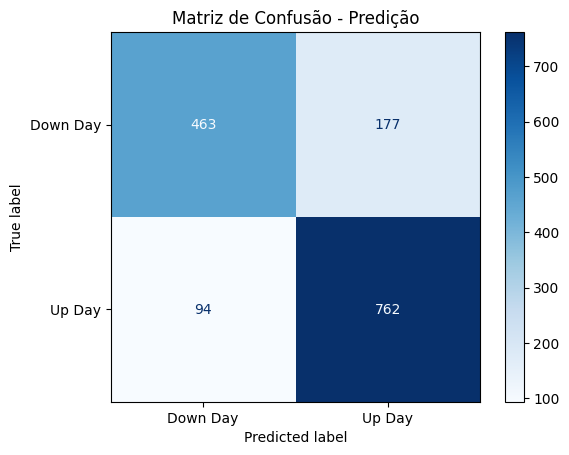

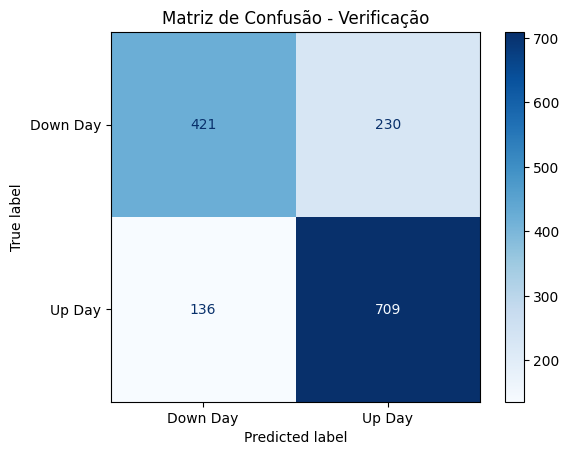

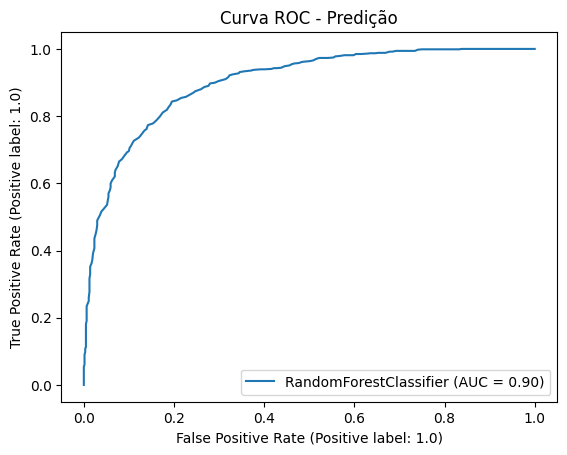

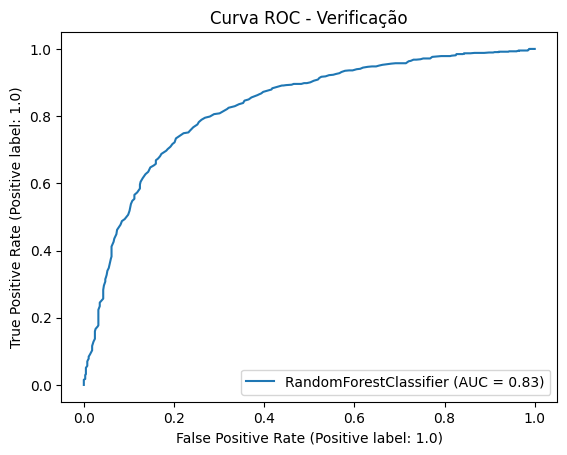

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Definir as colunas X e Y
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']  # Variável alvo para treinamento com preços suavizados
y_verify = price_data_Vale['Verify']  # Direção do preço real

# Dividir X e Y em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0)

# Ajustar os dados ao modelo
rand_frst_clf_Vale.fit(X_train, y_train)

# Fazer previsões com a direção de preço suavizada (Prediction)
y_pred = rand_frst_clf_Vale.predict(X_test)

# Calcular a acurácia com base na direção suavizada do preço ('Prediction')
accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)

# Alinhar os índices de y_test e y_verify para a comparação correta
accuracy_verify = accuracy_score(y_verify.loc[y_test.index], y_pred)  # Comparação com Verify, usando o mesmo índice de y_test

# Print resultados de acurácia
print(f'Acurácia com Y_test (Prediction): {accuracy_ytest:.4f}')
print(f'Acurácia com Verify: {accuracy_verify:.4f}')

# Função para calcular as métricas adicionais
def calculate_additional_metrics(y_true, y_pred):
    # Calculando a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Extraindo os valores da matriz de confusão
    tn, fp, fn, tp = cm.ravel()  # true_negatives, false_positives, false_negatives, true_positives
    
    # Calculando as métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    recall = recall_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    f1 = f1_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    specificity = tn / (tn + fp)  # Specificidade
    
    return accuracy, precision, recall, f1, specificity

# Calculando as métricas para 'Prediction' (y_test)
accuracy_pred, precision_pred, recall_pred, f1_pred, specificity_pred = calculate_additional_metrics(y_test, y_pred)

# Calculando as métricas para 'Verify' (y_verify)
y_verify_pred = rand_frst_clf_Vale.predict(X_test)  # As previsões já foram feitas com o modelo
accuracy_verify, precision_verify, recall_verify, f1_verify, specificity_verify = calculate_additional_metrics(y_verify.loc[y_test.index], y_verify_pred)

# Imprimindo as métricas calculadas
print(f"\nMétricas para 'Prediction':")
print(f"  Acurácia: {accuracy_pred:.4f}")
print(f"  Precisão: {precision_pred:.4f}")
print(f"  Recall: {recall_pred:.4f}")
print(f"  F1-Score: {f1_pred:.4f}")
print(f"  Specificidade: {specificity_pred:.4f}")

print(f"\nMétricas para 'Verify':")
print(f"  Acurácia: {accuracy_verify:.4f}")
print(f"  Precisão: {precision_verify:.4f}")
print(f"  Recall: {recall_verify:.4f}")
print(f"  F1-Score: {f1_verify:.4f}")
print(f"  Specificidade: {specificity_verify:.4f}")

# Matriz de Confusão para 'Prediction'
rf_matrix_pred = confusion_matrix(y_test, y_pred)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_pred, display_labels=['Down Day', 'Up Day'])
disp_pred.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Predição')
plt.show()

# Matriz de Confusão para 'Verify'
rf_matrix_verify = confusion_matrix(y_verify.loc[y_test.index], y_verify_pred)
disp_verify = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_verify, display_labels=['Down Day', 'Up Day'])
disp_verify.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Verificação')
plt.show()

# Curva ROC para 'Prediction'
rfc_disp_pred = RocCurveDisplay.from_estimator(rand_frst_clf_Vale, X_test, y_test)
plt.title('Curva ROC - Predição')
plt.show()

# Curva ROC para 'Verify'
rfc_disp_verify = RocCurveDisplay.from_estimator(rand_frst_clf_Vale, X_test, y_verify.loc[y_test.index])
plt.title('Curva ROC - Verificação')
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [113]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Vale, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [287]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Vale['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Vale['Prediction'] = rand_frst_clf_Vale.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Vale['Match'] = (price_data_Vale['Prediction'] == price_data_Vale['Verify']).astype(int)
overall_accuracy = price_data_Vale['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Vale[price_data_Vale['Date'] >= price_data_Vale['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Vale.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 80.78%

Precisão do modelo nos últimos 30 dias: 95.00%


#### Plotagem:

In [288]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'VALE3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=220, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Ambev.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Ambev.predict(X_Cols)

# Criando a figura
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
scatter_plotted = {"green": False, "red": False}  # Para controlar a legenda
for i in range(0, len(one_year_data), 30): 
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    label = "Predição de alta" if color == "green" else "Predição de baixa"

    # Para evitar repetição da legenda, plota uma vez cada cor
    if not scatter_plotted[color]:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label=label)
        scatter_plotted[color] = True
    else:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color)

# Configurações finais do gráfico
plt.xlabel("Data")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend(loc='upper left')
plt.grid(True, which="both", linestyle="--", linewidth=0.9)
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Exibe mais meses no eixo X

plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()
